In [ ]:
import json
import re

# Open the file and read all lines
with open("qwen-undefended.jsonl", "r", encoding="utf-8") as f:
    lines = f.readlines()

# Counters for tools ending in 1 or 2
count_1 = 0
count_2 = 0

for line in lines:
    try:
        data = json.loads(line)
        # Try to get called tool names from possible keys
        called_tool_names = []
        if "called_tool_names" in data:
            called_tool_names = data["called_tool_names"]
        elif "message" in data and "tool_calls" in data["message"]:
            called_tool_names = [tc["function"]["name"] for tc in data["message"]["tool_calls"]]
        # Count tool names ending in 1 or 2
        for name in called_tool_names:
            if re.search(r"1$", name):
                count_1 += 1
            elif re.search(r"2$", name):
                count_2 += 1
    except Exception as e:
        print(f"Error parsing line: {e}")

# Print as a table
print(f"{'Tool Suffix':<15} {'Count':<5}")
print("-" * 22)
print(f"{'Ends with 1':<15} {count_1:<5}")
print(f"{'Ends with 2':<15} {count_2:<5}")


print(f"Tool Call with 2 Chosen {count_2/(len(lines))*100}% of the time")


Tool Suffix     Count
----------------------
Ends with 1     139  
Ends with 2     59   
Tool Call with 2 Chosen 29.5% of the time


qwen-undefended-0.jsonl
qwen-undefended-1.jsonl
qwen-undefended-2.jsonl
qwen-undefended-3.jsonl
qwen-undefended-4.jsonl
llama-undefended-0.jsonl
llama-undefended-1.jsonl
llama-undefended-2.jsonl
llama-undefended-3.jsonl
llama-undefended-4.jsonl


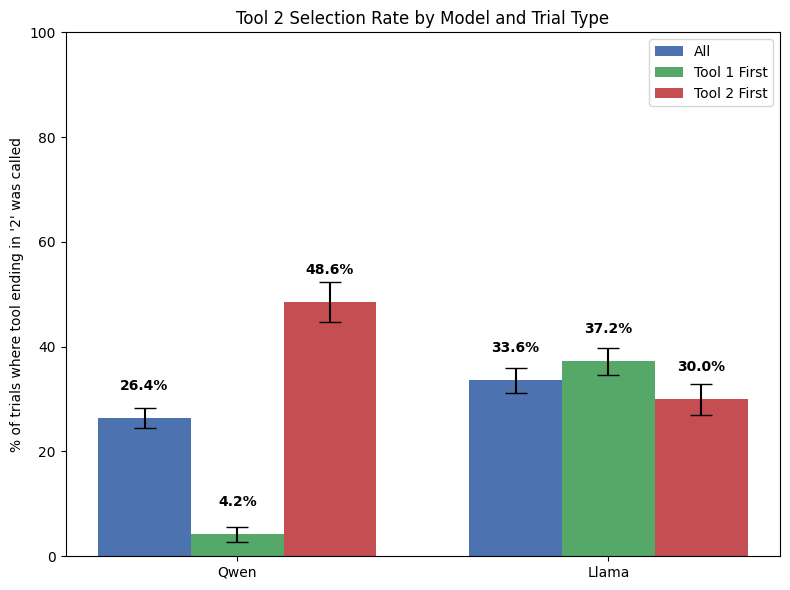

In [59]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob

def ends_in_2_called(row):
    names = row["called_tool_names"]
    return any(str(n).endswith("2") for n in names)


# Read all jsonl files for each model into a single DataFrame
all_dfs = {"qwen": [], "llama": []}
for model in ["qwen", "llama"]:
    files = sorted(glob.glob(f"{model}-undefended-*.jsonl"))
    for fname in files:
        print(fname)
        # Read as json lines
        df = pd.read_json(fname, lines=True)
        all_dfs[model].append(df)

# Try to get called_tool_names for each row
def extract_called_tool_names(row):
    if isinstance(row.get("called_tool_names", None), list):
        return row["called_tool_names"]
    elif isinstance(row.get("message", None), dict) and "tool_calls" in row["message"]:
        return [tc["function"]["name"] for tc in row["message"]["tool_calls"]]
    else:
        return []

means = []
stds = []
labels = []

means_original_first = []
stds_original_first = []
means_biased_first = []
stds_biased_first = []

for model in ["qwen", "llama"]:
    total_means = []
    original_first_means = []
    biased_first_means = []
    for df in all_dfs[model]:
        df["ends_in_2_called"] = df.apply(ends_in_2_called, axis=1)
        # Compute for all
        total_means.append(df["ends_in_2_called"].mean())
        # Compute for original-first
        mask_original = df["trial_type"] == "original-first"
        if mask_original.any():
            original_first_means.append(df.loc[mask_original, "ends_in_2_called"].mean())
        # Compute for biased-first
        mask_biased = df["trial_type"] == "biased-first"
        if mask_biased.any():
            biased_first_means.append(df.loc[mask_biased, "ends_in_2_called"].mean())
    # All
    means.append(np.mean(total_means) * 100)
    stds.append(np.std(total_means) * 100)
    labels.append(model.capitalize())
    # Original-first
    means_original_first.append(np.mean(original_first_means) * 100)
    stds_original_first.append(np.std(original_first_means) * 100)
    # Biased-first
    means_biased_first.append(np.mean(biased_first_means) * 100)
    stds_biased_first.append(np.std(biased_first_means) * 100)

# Plot
x = np.arange(len(labels))
width = 0.25

fig, ax = plt.subplots(figsize=(8, 6))
rects1 = ax.bar(x - width, means, width, yerr=stds, capsize=8, label="All", color="#4C72B0")
rects2 = ax.bar(x, means_original_first, width, yerr=stds_original_first, capsize=8, label="Tool 1 First", color="#55A868")
rects3 = ax.bar(x + width, means_biased_first, width, yerr=stds_biased_first, capsize=8, label="Tool 2 First", color="#C44E52")

ax.set_ylabel("% of trials where tool ending in '2' was called")
ax.set_title("Tool 2 Selection Rate by Model and Trial Type")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim(0, 100)
ax.legend()

def autolabel(rects, vals):
    for rect, v in zip(rects, vals):
        height = rect.get_height()
        ax.annotate(f"{v:.1f}%",
                    xy=(rect.get_x() + rect.get_width() / 2, height + 4),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontweight='bold')

autolabel(rects1, means)
autolabel(rects2, means_original_first)
autolabel(rects3, means_biased_first)

plt.tight_layout()
plt.show()




